In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_train = pd.read_csv("../data/spotify_dataset_train.csv")
df_test = pd.read_csv("../data/spotify_dataset_test.csv")

In [3]:
df_train_copy = df_train.copy() # pour eviter les pb

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train_copy['genre']=le.fit_transform(df_train_copy['genre'])


FEATURES = list( df_train.columns[1:] )# retirer la date pour simplifier
df_train_clean = df_train_copy[FEATURES]
df_train_clean['explicit'] = df_train_clean['explicit'].astype(int) 
dummy_df = pd.get_dummies(df_train_clean)
df_train_clean.head()

,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0,38,0.509,0.8720,2,-5.170,1,0.0547,0.0396,0.000015,0.3310,0.4860,95.969,194375,4,3
1,0,58,0.182,0.0377,11,-33.748,0,0.0391,0.9870,0.957000,0.0804,0.0923,100.482,241804,4,2
2,0,36,0.550,0.9410,0,-3.128,0,0.0849,0.0182,0.003750,0.3120,0.3510,145.006,260276,4,16
3,0,0,0.569,0.7190,6,-8.399,0,0.0663,0.8670,0.941000,0.1760,0.6430,145.118,165200,4,0
4,0,0,0.631,0.6610,8,-5.694,1,0.0558,0.0146,0.720000,0.3650,0.3300,130.004,245933,4,4


## Dimension reduction


In [ ]:
Y = df_train_clean.iloc[:,-1:]
X = df_train_clean.iloc[:,:-1]
X = X.to_numpy()
Y = Y.to_numpy()

In [12]:
# Manual standardization using ddof=1
mean = np.mean(X, axis=0)
std = np.std(X, axis=0, ddof=1)  # Using sample standard deviation
Z_manual = (X - mean) / std

# Verify the variance is now 1 (using ddof=1)
print('Variances after manual scaling:', Z_manual.var(axis=0, ddof=1)) # Should be ~1.0



Variances after manual scaling: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
from sklearn.decomposition import PCA

# Now apply PCA
pca = PCA(n_components=15)
pca.fit(Z_manual)

eigenvalues = (pca.singular_values_ ** 2) / (Z_manual.shape[0] - 1)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
print(pca.singular_values_)
eigenvalues = (pca.singular_values_ ** 2) / (Z_manual.shape[0] - 1)
print('Eigenvalues sum:', eigenvalues.sum())

[0.1827662  0.1164017  0.08896571 0.08119212 0.07077487 0.07026143
 0.06335988 0.05857386 0.05486116 0.05432723 0.05156396 0.03501569
 0.03312685 0.02815827 0.01065108]
[0.1827662  0.2991679  0.38813361 0.46932573 0.5401006  0.61036203
 0.6737219  0.73229577 0.78715693 0.84148416 0.89304812 0.92806381
 0.96119066 0.98934892 1.        ]
[264.35468501 210.96903628 184.43799087 176.1959897  164.50480961
 163.90702267 155.64895954 149.6549169  144.83434486 144.12783572
 140.41457652 115.70987624 112.54575389 103.76287874  63.81691622]
Eigenvalues sum: 14.999999999999988


In [18]:
n_componentes_90 = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.95) + 1
print(f'Components required for 95% variance: {n_componentes_90}')

Components required for 95% variance: 13


In [22]:
kaiser_criterion = eigenvalues > 1
n_components_kaiser = sum(kaiser_criterion)

print("Eigenvalues:", eigenvalues)
print("Does it comply with Kaiser's rule?", kaiser_criterion)
print("Number of components to be preserved:", n_components_kaiser)

Eigenvalues: [2.74149306 1.74602543 1.3344856  1.21788187 1.06162302 1.05392147
 0.95039813 0.87860791 0.8229174  0.81490852 0.77345939 0.5252354
 0.4969027  0.42237398 0.15976614]
Does it comply with Kaiser's rule? [ True  True  True  True  True  True False False False False False False
 False False False]
Number of components to be preserved: 6


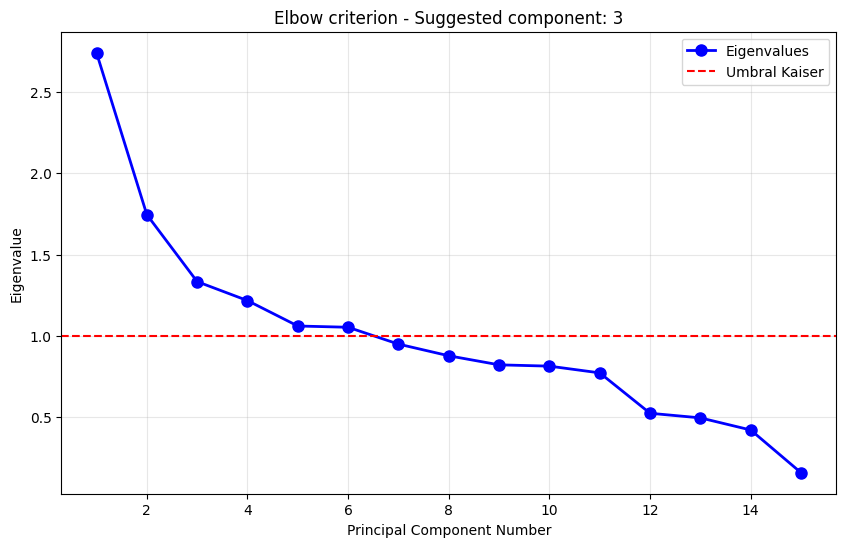

In [21]:
# Gráfica con el codo marcado
plt.figure(figsize=(10, 6))
plt.plot(component_numbers, eigenvalues, 'bo-', linewidth=2, markersize=8, label='Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--', label='Umbral Kaiser')


plt.xlabel('Principal Component Number')
plt.ylabel('Eigenvalue')
plt.title(f'Elbow criterion - Suggested component: {elbow_component}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Resampling Values

C:\Users\alfar\AppData\Local\Temp\ipykernel_768\1161970130.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_generos.index, y=conteo_generos.values, palette='viridis')


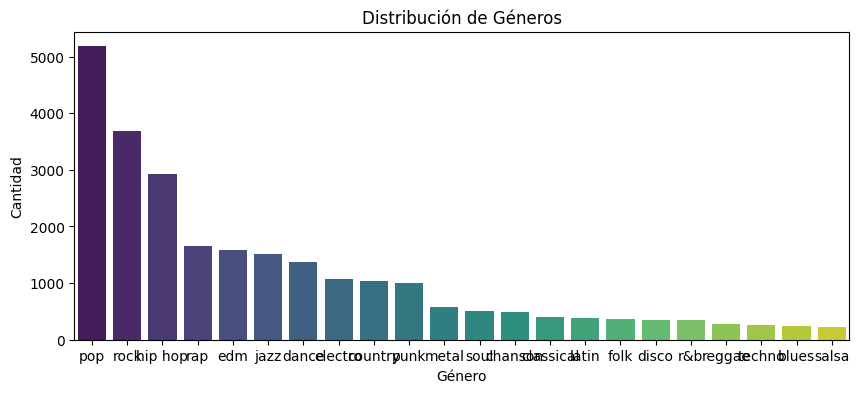

In [12]:


# Contar la cantidad de cada género
conteo_generos = df_train['genre'].value_counts()

# Crear el histograma
plt.figure(figsize=(10, 4))
sns.barplot(x=conteo_generos.index, y=conteo_generos.values, palette='viridis')
plt.title('Distribución de Géneros')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()


### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE